# Forward Modeling HVSR

inspired by Herak (2008)

## 1. Import packages

In [12]:
import numpy as np
import matplotlib.pyplot as plt

## 2. Fungsi AMP dan H/V

### Fungsi AMP dari Tsai (1980)

In [2]:
def AMP(vel, density, H, Q, k_Q, Fref, F):
    """
    """
    # velocity length
    len_V = len(vel)

    # frequency length
    len_F = len(F)

    # generate variables
    AMP = np.zeros(len_F)
    A = np.zeros(len_V, dtype='complex_')
    B = np.zeros(len_V, dtype='complex_')
    S = np.zeros(len_V, dtype='complex_')
    alpha = np.zeros(len_V, dtype='complex_')

    # starting values
    A[0] = 1
    B[0] = 1

    for i in range(len_F):

        for j in range(1, len_V):

            # frequency-dependent velocity
            if Fref != 0:

                # still haven't known yet the reference, Invert Q filter by downward continuation (?)
                # in Compensating for attenuation by inverse Q filtering (Crewes, 2004) (?)
                FAC = np.sqrt( 2 / (1 + np.sqrt(1 + (Q[j] * F[i]**k_Q)**(-2))) * (1 - 1j/(Q[j] * F[i]**k_Q)) )
                FACm1 = np.sqrt( 2 / (1 + np.sqrt(1 + (Q[j - 1] * F[i]**k_Q)**(-2))) * (1 - 1j/(Q[j - 1] * F[i]**k_Q)) )

                vj = vel[j] * (1 + 1/(np.pi * (Q[j] * F[i]**k_Q)) * np.log(F[i]/Fref)) / FAC
                vjm1 = vel[j - 1] * (1 + 1/(np.pi * (Q[j - 1] * F[i]**k_Q)) * np.log(F[i]/Fref)) / FACm1
            else:
                vj = vel[j]
                vjm1 = vel[j - 1]            

            # impedance ratio
            alpha[j - 1] = (density[j - 1] * vjm1) / (density[j] * vj)

            # Equation (7) Tsai 1970 -> s = k * H -> k = w / c
            S[j - 1] = (2 * np.pi * F[i] * H[j - 1] / vjm1)

            # Equation (10) Tsai 1970 -> matrix equation (?)
            A[j] = 0.5 * ( (1 + alpha[j - 1]) * np.exp(1j*S[j - 1]) * A[j - 1] + 
                          (1 - alpha[j - 1]) * np.exp(-1j*S[j - 1]) * B[j - 1] )
            B[j] = 0.5 * ( (1 - alpha[j - 1]) * np.exp(1j*S[j - 1]) * A[j - 1] + 
                          (1 + alpha[j - 1]) * np.exp(-1j*S[j - 1]) * B[j - 1] )


        AMP[i] = 1/np.absolute(A[len_V - 1])
        # ReIm = np.exp(1j * S[0]) * A[-1] / A[0]
        # AMP[i] = 1/np.absolute(ReIm)

    return AMP

### Fungsi H/V

Pada bagian ini, asumsi Vp dan densitas dapat didekati dengan persamaan empiris

In [5]:
def HV(vp, vs, density, H, Qp, Qs, k_Q, Fref, F):
    """
    """
    AMPp = AMP(vp, density, H, Qp, k_Q, Fref, F)
    AMPs = AMP(vs, density, H, Qs, k_Q, Fref, F)
    return AMPs/AMPp

def Vs2Vp(Vs):
    """
    """
    Vs = Vs / 1000
    return 1000 * (0.9409 + 2.0947 * Vs - 0.8206 * np.power(Vs, 2) + 0.2683 * np.power(Vs, 3) - 0.0251 * np.power(Vs, 4))

def Vp2Density(Vp):
    """
    """
    Vp = Vp / 1000
    return 1.6612 * Vp - 0.4721 * np.power(Vp, 2) + 0.0671 * np.power(Vp, 3) - 0.0043 * np.power(Vp, 4) + 0.000106 * np.power(Vp, 5)

def HVe(vs, H, Qp, Qs, k_Q, Fref, F):
    """
    Use Vs2Vp() and Vp2Density() functions to estimate vp and density
    """
    vp = Vs2Vp(vs)
    density = Vp2Density(vp)
    return HV(vp, vs, density, H, Qp, Qs, k_Q, Fref, F)

## 3. Implementasi

### Set model

In [13]:
vs = np.array([375., 2000., 1000., 3000.])
H = np.array([10., 5., 20.])
Qp = np.array([15, 30, 60, 100])
Qs = np.array([5, 10, 20, 50])
k_Q = 0.25
F = np.logspace(np.log10(0.5),np.log10(50),100)
Fref = 1

### Fungsi plot model

In [14]:
def plot_v(vs, H, color='grey', linewidth=1, linestyle='-', ax = None, label="v", zorder=None):
    cumH = np.cumsum(H)
    cumH = np.append(cumH, cumH[-1] + H[-1])
    cumH = np.insert(cumH, 0, 0)
    
    vs = np.insert(vs, 0, vs[0])
    if ax is None:
        line, = plt.step(vs, cumH, where="post", color=color, linestyle=linestyle, linewidth=linewidth, zorder=zorder, label=label)
    else:
        line, = ax.step(vs, cumH, where="post", color=color, linestyle=linestyle, linewidth=linewidth, zorder=zorder, label=label)
    
    return line

### Tampilan model

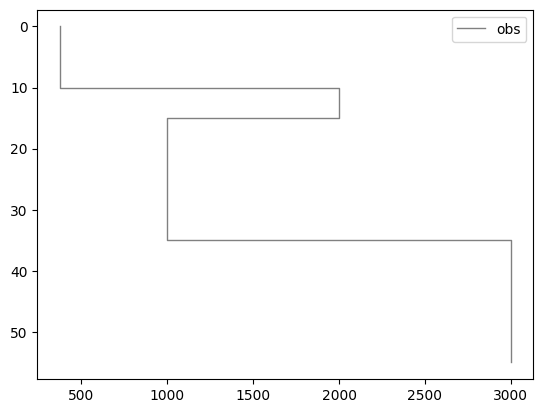

In [15]:
plot_v(vs, H, label="obs")
plt.gca().invert_yaxis()
plt.legend()

### Forward modeling -> Kurva HVSR

[]

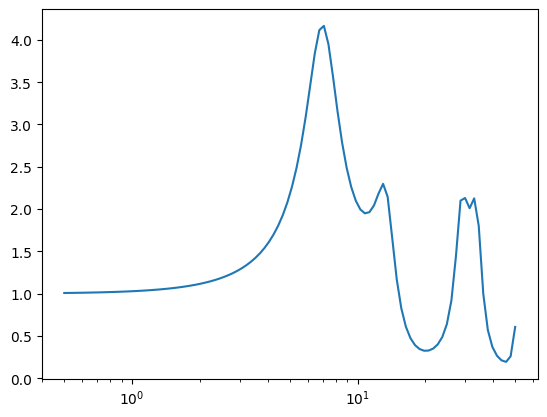

In [17]:
hv_calc = HVe(vs, H, Qp, Qs, k_Q, Fref, F)

plt.plot(F, hv_calc)
plt.semilogx()